This chapter is to show the wider and deeper application of PyTorch.

In previous image classification tasks, the model's output is either 0 or 1. mixup is a technique to make model target for making predictions with probabilities. Before trying it we need to set up the dataset as usual. Clone a folder from ./drive/MyDrive/image_classification_test/ (should be available after studying previous chapters) to a new folder ./drive/MyDrive/image_classification_test_mixup, and in this new folder, move half of the images from train folder to a new folder named mix.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# PIL is a widely used python image library
import PIL
from PIL import Image, ImageFile

import torchvision
from torchvision import transforms
from torch.utils import data

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

# this is to prevent image file to be too large
ImageFile.LOAD_TRUNCATED_IMAGES = True 

workspace_path = "./drive/MyDrive/image_classification_test_mixup/"
train_data_path = workspace_path + "/train/"
val_data_path = workspace_path + "/val/"
test_data_path = workspace_path + "/test/"
mix_data_path = workspace_path + "/mix/"

# check if this image exists
img = Image.open(val_data_path + "/fish/100_1422.JPG")
print(img.size)

(512, 342)


In [ ]:
# this function is very important, otherwise quite a few images won't be opened successfully, causing script's runtime error.
def check_image(path):
  try:
    Image.open(path)
    return True
  except:
    return False

img_transforms = transforms.Compose([
    transforms.Resize((64, 64)), # resize image
    transforms.ToTensor(), # store image data in tensor
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    # the above normalization follows distribution of ImageNet dataset
    ])

train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = img_transforms, is_valid_file=check_image)

val_data = torchvision.datasets.ImageFolder(root = val_data_path, transform = img_transforms, is_valid_file=check_image)

test_data = torchvision.datasets.ImageFolder(root = test_data_path, transform = img_transforms, is_valid_file=check_image)

mix_data = torchvision.datasets.ImageFolder(root = mix_data_path, transform = img_transforms, is_valid_file=check_image)

# load data in a batch
batch_size = 4
train_data_loader = data.DataLoader(train_data, batch_size = batch_size)
val_data_loader = data.DataLoader(val_data, batch_size = batch_size)
test_data_loader = data.DataLoader(test_data, batch_size = batch_size)
mix_data_loader = data.DataLoader(mix_data, batch_size = batch_size)
# check how many images get loaded
print(len(train_data_loader.dataset))
print(len(val_data_loader.dataset))
print(len(test_data_loader.dataset))
print(len(mix_data_loader.dataset))


# adjust the image number in each folder if the following assertions fail
assert len(train_data_loader.dataset) == len(mix_data_loader.dataset)
assert len(train_data_loader.dataset) % batch_size == 0
assert len(val_data_loader.dataset) % batch_size == 0
assert len(test_data_loader.dataset) % batch_size == 0

In [ ]:
class cnn_net(nn.Module):
    # num_classes is for how many target categories for image classification
    def __init__(self, num_classes=2):
        super(cnn_net, self).__init__()
        # search for nn.Sequential for more info if needed; basically it can be used
        # as a block of layers, used to build a larger network
        rgb_channel_num = 3
        final_output_feature = 256
        self.features = nn.Sequential(
            # search for Conv2d's parameters like stride, padding for more info
            # check this https://stackoverflow.com/a/49818579 for knowledge about how are 
            # conv2d weights are initialized by default
            nn.Conv2d(rgb_channel_num, 64, kernel_size = 11, stride = 4, padding = 2),
            # introduced in Chapter 2
            nn.ReLU(),
            # search for MaxPool2d for more info if needed
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            # note the relationship between each layer's output channel number and
            # the next layer's input channel number
            nn.Conv2d(64, 192, kernel_size = 5, padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(192, 384, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, final_output_feature, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
        )
        # search for AdaptiveAvgPool2d for more info if needed
        avg_pool_kernel_size = (6, 6)
        self.avg_pool = nn.AdaptiveAvgPool2d(avg_pool_kernel_size)
        self.classifier = nn.Sequential(
            # search for Dropout for more info if needed, an important method for 
            # model generalisation
            # note the affect of dropout ratio here, which is 0.5 by default.
            # Also note the behavioral difference for Dropout layer between training mode 
            # and eval mode
            nn.Dropout(),
            # search for nn Linear's definition if needed
            # note the relationship between each layer's output channel number and
            # the next layer's input channel number
            nn.Linear(final_output_feature * avg_pool_kernel_size[0] * avg_pool_kernel_size[1], 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            # note the final output layer should match num_classes
            nn.Linear(4096, num_classes)
        )

    # note how the Sequentials defined above are used in forwarding
    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool(x)
        # reshape into one dimension
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

The difference is that in training we are going to apply a new loss function. The related paper is https://arxiv.org/abs/1710.09412.


In [ ]:
my_model = cnn_net()
# search for Adam optimizer for more info if needed
# note learning rate 3e-4 is quite famous, as it was recommended widely in academic research
# using a even smaller learning rate has a better chance to learn with small dataset
# using a larger learning rate would cause the network to learn very slowly
optimizer = optim.Adam(my_model.parameters(), lr = 0.0001)

# copy the model to device
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
my_model.to(device)

def loss_update_mixup(model, batch, loss_fn, device, check_result):
    (inputs, targets), (inputs_mix, targets_mix) = batch
    inputs = inputs.to(device)
    targets = targets.to(device)
    inputs_mix = inputs_mix.to(device)
    targets_mix = targets_mix.to(device)

    distribution = torch.distributions.beta.Beta(0.5, 0.5)
    # expand the distribution parameters in NCHW format
    beta = distribution.expand(torch.zeros(batch_size).shape).sample().to(device)
    mixup = beta[:, None, None, None]
    
    output = model(mixup * inputs + (1 - mixup) * inputs)
    target_final = (beta * targets + (1 - beta) * targets_mix).to(dtype = torch.long)
    loss = loss_fn(output, target_final)
    num_current_correct = 0
    if (check_result):
        result = torch.eq(torch.max(F.softmax(output, dim = 1), dim = 1)[1], target_final)
        num_current_correct = torch.sum(result).item()
    return loss, num_current_correct

def train_mixup(model, optimizer, loss_fn, train_data_loader, val_data_loader, mix_data_loader, epochs, device):
  for epoch in range(epochs):
    training_loss = 0.0
    valid_loss = 0.0
    # this is to set model in training mode
    model.train()
    check_result = False
    # training process
    for batch in zip(train_data_loader, mix_data_loader):
      optimizer.zero_grad()
      loss = loss_update_mixup(model, batch, loss_fn, device, check_result)[0]
      loss.backward()
      optimizer.step()
      training_loss += loss.data.item() * batch_size
    training_loss /= len(train_data_loader.dataset)

    # this is to set model in evaluation mode
    model.eval()
    check_result = True
    num_correct = 0
    num_examples = 0
    for batch in zip(val_data_loader, mix_data_loader):
      loss, num_current_correct= loss_update_mixup(model, batch, loss_fn, device, check_result)
      valid_loss += loss.data.item() * batch_size
      num_correct += num_current_correct
      num_examples += batch_size
    valid_loss /= len(val_data_loader.dataset)

    print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss, valid_loss, num_correct / num_examples))

# modify the number of epochs to check how loss and accuracy changes with more training
# note this model needs a few more epochs to learn
train_mixup(my_model, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, mix_data_loader, 2, device)

Another way of mixing up is to perform shuffling on the train data loader, to relax the requirement that the data loader must be balanced across batches.

In [ ]:
def loss_update_mixup_shuffle(model, batch, loss_fn, device, check_result):
    (inputs, targets) = batch
    shuffle = torch.randperm(inputs.size(0))
    inputs = inputs.to(device)
    targets = targets.to(device)
    inputs_mix = inputs[shuffle]
    targets_mix = targets[shuffle]

    distribution = torch.distributions.beta.Beta(0.5, 0.5)
    # expand the distribution parameters in NCHW format
    beta = distribution.expand(torch.zeros(batch_size).shape).sample().to(device)
    mixup = beta[:, None, None, None]
    
    output = model(mixup * inputs + (1 - mixup) * inputs)
    target_final = (beta * targets + (1 - beta) * targets_mix).to(dtype = torch.long)
    loss = loss_fn(output, target_final)
    num_current_correct = 0
    if (check_result):
        result = torch.eq(torch.max(F.softmax(output, dim = 1), dim = 1)[1], target_final)
        num_current_correct = torch.sum(result).item()
    return loss, num_current_correct

def train_mixup_shuffle(model, optimizer, loss_fn, train_data_loader, val_data_loader, epochs, device):
  for epoch in range(epochs):
    training_loss = 0.0
    valid_loss = 0.0
    # this is to set model in training mode
    model.train()
    check_result = False
    # training process
    for batch in train_data_loader:
      optimizer.zero_grad()
      loss = loss_update_mixup_shuffle(model, batch, loss_fn, device, check_result)[0]
      loss.backward()
      optimizer.step()
      training_loss += loss.data.item() * batch_size
    training_loss /= len(train_data_loader.dataset)

    # this is to set model in evaluation mode
    model.eval()
    check_result = True
    num_correct = 0
    num_examples = 0
    for batch in val_data_loader:
      loss, num_current_correct= loss_update_mixup_shuffle(model, batch, loss_fn, device, check_result)
      valid_loss += loss.data.item() * batch_size
      num_correct += num_current_correct
      num_examples += batch_size
    valid_loss /= len(val_data_loader.dataset)

    print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss, valid_loss, num_correct / num_examples))

# modify the number of epochs to check how loss and accuracy changes with more training
# note this model needs a few more epochs to learn
train_mixup_shuffle(my_model, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, 2, device)

Label Smoothing is another way to make model provide a less determined prediction result, and often gains a better accuracy improvement during training. It applies a new loss function, as can be seen in the following, which makes the prediction output be 1 minus epsilon. Epsilon is a small valued parameter.

In [ ]:
class LabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self, epsilon = 0.1):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        self.epsilon = epsilon
    def forward(self, output, target):
        num_classes = output.size()[-1]
        log_preds = F.log_softmax(output, dim = -1)
        loss = (-log_preds.sum(dim = -1)).mean()
        # negative log likelihood loss
        nll = F.nll_loss(log_preds, target)
        return self.epsilon * loss / num_classes + (1 - self.epsilon) * nll


According to the book, label smoothing works well with mixup.

In [ ]:
train_mixup_shuffle(my_model, optimizer, LabelSmoothingCrossEntropyLoss(), train_data_loader, val_data_loader, 2, device)

In the following we are going to define a super-resolution model. The key layer is the upsample layer. 

In [ ]:
class sr_net(nn.Module):
    def __init__(self):
        super(sr_net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 8, stride = 4, padding = 2),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 192, kernel_size = 2, padding = 2),
            nn.ReLU(inplace = True),
            nn.Conv2d(192, 256, kernel_size = 2, padding = 2),
            nn.ReLU(inplace = True)
        )
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(256, 192, kernel_size = 2, padding = 2),
            nn.ReLU(inplace = True),
            nn.ConvTranspose2d(192, 64, kernel_size = 2, padding = 2),
            nn.ReLU(inplace = True),
            nn.ConvTranspose2d(64, 3, kernel_size = 8, stride = 4, padding = 2),
            nn.ReLU(inplace = True),
            nn.ConvTranspose2d(3, 3, kernel_size = 2, stride = 2),
            nn.ReLU(inplace = True),
            nn.Conv2d(3, 3, kernel_size = 2, stride = 2),
            nn.ReLU(inplace = True),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.upsample(x)
        return x

my_model = sr_net()
output = my_model(torch.rand(1, 3, 224, 224))
print(output.shape)

GAN is a way of feeding more data to neural networks by adding a generator in the network and train the network to distinguish between real data and generated data. The book doesn't provide a solid example of GAN, so we will skip the code demo.

ESRGAN applies GAN for image super-resolution enhancement. We are going to try it out. In Google Drive, create a new folder called esrgan_test. The steps are from https://github.com/xinntao/ESRGAN.

In [ ]:
%cd /content/drive/MyDrive/esrgan_test/
!git clone https://github.com/xinntao/ESRGAN

Download the model from https://drive.google.com/drive/u/0/folders/17VYV_SoZZesU6mbxz2dMAIccSSlqLecY (select the RRDB_ESRGAN_x4.pth, details in https://github.com/xinntao/ESRGAN/blob/master/models/README.md) and put it in esrgan_test/models/ folder.

In test.py, update the model path and test_img_folder, and the final cv imwrite location.

You can put new input images in the LR folder. Here we are going to use the ones provided by the author.

In [ ]:
# run the script and check the output in results folder.
!rm -rf /content/drive/MyDrive/esrgan_test/ESRGAN/results/*
!python /content/drive/MyDrive/esrgan_test/ESRGAN/test.py

The following shows an example of using Facebook's Mask R-CNN for object detection and segmentation. The repo is at https://github.com/facaebookresearch/maskrcnn-benchmark. In Google Drive, create a new folder named mask_rcnn_test.

In [ ]:
%cd /content/drive/MyDrive/mask_rcnn_test/
!git clone https://github.com/facebookresearch/maskrcnn-benchmark

Add the following code in test.py in demo folder. Also put an input image in demo folder, like "demo/input.jpg".



In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import sys
from maskrcnn_benchmark.config import cfg
from predictor import COCODemo

config_file = "../configs/caffe2/e2e_faster_rcnn_R_101_FPN_1x_caffe2.yaml"

cfg.merge_from_file(config_file)
cfg.merge_from_list(["MODEL.DEVICE", "cpu"])

coco_demo = COCODemo(
    cfg,
    min_image_size = 500,
    confidence_threshold = 0.7,
)

img = Image.open(sys.argv[1])
# turn into BGR format as the demo is trained on BGR images
img = np.array(img)[:, :, [2, 1, 0]]
predictions = coco_demo.run_on_opencv_image(image)
predictions = predictions[:, :, ::-1]

plt.imsave(sys.argv[2], predictions)

In [ ]:
!pip install ninja yacs

In [ ]:
%cd /content/drive/MyDrive/mask_rcnn_test/
!git clone https://github.com/NVIDIA/apex.git
%cd /content/drive/MyDrive/mask_rcnn_test/apex
# commenting out Line check_cuda_torch_binary_vs_bare_metal to suppress checking error
!python setup.py install --cuda_ext --cpp_ext

In /content/drive/MyDrive/mask_rcnn_test/maskrcnn-benchmark/maskrcnn_benchmark/csrc/cuda, on the top of deform_conv_cuda.cu and deform_pool_cuda.cu, add the following code (check https://github.com/mrlooi/rotated_maskrcnn/issues/31 for details).

In [ ]:
#ifndef AT_CHECK
#define AT_CHECK TORCH_CHECK 
#endif

In [ ]:
%cd /content/drive/MyDrive/mask_rcnn_test/maskrcnn-benchmark/
%
!python setup.py build develop
%cd /content/drive/MyDrive/mask_rcnn_test/maskrcnn-benchmark/demo

In [ ]:
# run the test
%cd /content/drive/MyDrive/mask_rcnn_test/maskrcnn-benchmark/demo
# in utils/imports.py, modify torch._six.PY3 to be torch._six.PY37
# do the same for c2_model_loading.py
!python3 test.py /content/drive/MyDrive/mask_rcnn_test/maskrcnn-benchmark/demo/input.jpg /content/drive/MyDrive/mask_rcnn_test/maskrcnn-benchmark/demo/output.jpg
# check the output image, as can be seen a bounding box is marked on the image

The book provides an example of adversarial samples, which can be used to make a neural network confused in tests like image classification, as shown in the following. In Google Drive, make a new directory called model_break_test and copy the casper2.jpg from Chapter 7 into it.

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
from torch.nn import functional as F

img = Image.open("./drive/MyDrive/model_break_test/casper2.jpg")
my_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()                                
])
img_tensor = my_transform(img).unsqueeze(0)
my_model = models.resnet18(pretrained = True)
my_model.eval()
prediction = my_model(img_tensor)
pred_probabilities = F.softmax(prediction, dim = 1).data.squeeze()
print("before breaking, the output result is")
target = torch.topk(pred_probabilities, 1)[1]
print(target.item())


before breaking, the output result is
283


Then we are going to create a misleading image and send it to the neural network.

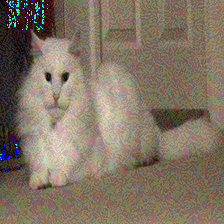

after breaking, the output result is
794


In [ ]:
from IPython.display import display

def add_fake_mask(input, label, loss_function, model):
    epsilon = 0.05
    model.train()
    input.requires_grad = True
    output = model(input)
    loss = loss_function(output, label)
    # search for the usage of retain_graph if needed
    loss.backward(retain_graph = True)
    return torch.sign(input.grad) * epsilon

adversarial_mask = add_fake_mask(img_tensor, target, torch.nn.CrossEntropyLoss(), my_model)
adversarial_image = adversarial_mask + img_tensor

# display the misleading image
display(transforms.ToPILImage()(adversarial_image.squeeze()))
# check the new output
my_model.eval()
prediction = my_model(adversarial_image)
pred_probabilities = F.softmax(prediction, dim = 1).data.squeeze()
print("after breaking, the output result is")
target = torch.topk(pred_probabilities, 1)[1]
# check https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a for the output category
print(target.item())

FastBERT is a python library to take advantage of the famous BERT model (from Google, a transformer based, large scale model) and can be applied to the text classification test in Chapter 5.

In [5]:
!pip install fast-bert

     |████████████████████████████████| 99 kB 5.7 MB/s 
     |████████████████████████████████| 124 kB 52.2 MB/s 
     |████████████████████████████████| 3.0 MB 46.5 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 769 kB 37.7 MB/s 
     |████████████████████████████████| 895 kB 36.7 MB/s 
     |████████████████████████████████| 1.2 MB 29.4 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=e4656762a84820ffde03d28c252886ad666dd100c2d435c381671c770149d5cc
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In Google Drive, create a new folder named "bert_test" and copy the train-processed-sample.csv from Chapter "Text_Classification" into it.

In [6]:
import pandas as pd
import numpy as np

workspace_path = "./drive/MyDrive/bert_test"
file_path = workspace_path + "/train-processed-sample.csv"

df = pd.read_csv(file_path, encoding='latin-1')
df = df.drop(df.columns[[0, 1, 2, 3, 4, 6]], axis=1)
df.columns = ['text', 'label']

np.random.seed(0)
train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

train_file_name = "train.csv"
val_file_name = "val.csv"
test_file_name = "test.csv"
label_file_name = "labels.csv"

train.to_csv(workspace_path + "/" + train_file_name, index=False)
val.to_csv(workspace_path + "/" + val_file_name, index=False)
test.to_csv(workspace_path + "/" + test_file_name, index=False)

labels = pd.DataFrame(df.label.unique())
labels.to_csv(workspace_path + "/" + label_file_name, header=False, index=False)

In [13]:
import torch
import logging

from transformers import BertTokenizer
from fast_bert.data_cls import BertDataBunch
from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy

device = torch.device("cuda")
logger = logging.getLogger()
metrics = [{"name" : "accuracy", "function" : accuracy}]

model_type = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(
    model_type, do_lower_case = True
)
databunch = BertDataBunch(
    workspace_path,
    workspace_path,
    tokenizer,
    train_file_name,
    val_file_name,
    test_file_name,
    text_col = 0,
    label_col = 1,
    batch_size_per_gpu = 32,
    max_seq_length = 140,
    multi_gpu = False,
    multi_label = False,
    model_type = "bert"
)

learner = BertLearner.from_pretrained_model(
    databunch,
    model_type,
    metrics = metrics,
    device = device,
    logger = logger,
    output_dir = workspace_path,
    is_fp16 = False,
    multi_gpu = False,
    multi_label = False
)
# start training, note it could take quite long for a single epoch to run
learner.fit(3, lr = 1e-2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

/usr/local/lib/python3.7/dist-packages/pytorch_lamb/lamb.py:96: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(564, 0.6982564772908569)

GPT-2 is a nice model from OpenAI and shows ability to "create incredibly realistic text". The process to reproduce the text generation task result has high dependence on libraries out of PyTorch, so we will skip this part. The example can be observed here https://deepai.org/machine-learning-model/text-generator.

Another popular model in text classification is ULMFit. The example is based on fast.ai, which is a deep-learning library that will be covered in another book. ULMFit has comparable performance to BERT in text classification, with a smaller scale.